### Use pretained model that detect contours



In [7]:
# pip install -U controlnet-aux diffusers Pillow torch
# (diffusers is used here only for load_image convenience; you can use PIL directly too)

import torch
from controlnet_aux import HEDdetector
from diffusers.utils import load_image
from PIL import Image

def run_hed(
    image_path_or_url: str,
    out_path: str = "hed_edges.png",
    device: str | None = None,
):
    """
    Runs HED edge detection and saves an edge-map image (contours).
    Output is a PIL Image (typically grayscale-like edge map).
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load image (local path OR URL)
    img = load_image(image_path_or_url).convert("RGB")

    # Load pretrained HED annotator weights from Hugging Face
    # IMPORTANT: Use 'lllyasviel/Annotators' (recommended by HF discussions/README updates)
    hed = HEDdetector.from_pretrained("lllyasviel/Annotators").to(device)

    # Run detector
    # Output: PIL.Image (edge map)
    edges: Image.Image = hed(img)

    # Save
    edges.save(out_path)
    return img, edges

if __name__ == "__main__":
    # Example: local file path
    # original, edges = run_hed("my_bio_image.png", out_path="my_bio_image_hed.png")

    # Example: URL
    original, edges = run_hed(
        "/Physionet_ECG challenge/data/10140238/10140238-0001.png",
        out_path="hed_edges.png",
    )

    print("Saved:", "hed_edges.png")


Saved: hed_edges.png


In [8]:
# pip install -U transformers pillow torch opencv-python

import torch
import numpy as np
import cv2
from PIL import Image
from transformers import Sam2Processor, Sam2ForImageSegmentation

def mask_to_contours(mask: np.ndarray):
    """
    mask: HxW, values {0,1} or {0,255}
    returns: list of contours (OpenCV format)
    """
    m = (mask > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

def run_sam2_point_prompt(
    image_path: str,
    point_xy: tuple[int, int],          # (x, y) pixel coordinate on the curve
    out_mask_path: str = "sam2_mask.png",
    out_contours_path: str = "sam2_contours.png",
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Load SAM2 from Hugging Face
    processor = Sam2Processor.from_pretrained("facebook/sam2-hiera-large")
    model = Sam2ForImageSegmentation.from_pretrained("facebook/sam2-hiera-large").to(device)

    # Point prompt: one foreground point (label=1)
    input_points = [[[list(point_xy)]]]   # batch=1, num_objects=1, num_points=1, xy
    input_labels = [[[1]]]                # 1 = foreground

    inputs = processor(
        images=image,
        input_points=input_points,
        input_labels=input_labels,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process masks back to original image size
    masks = processor.post_process_masks(
        outputs.pred_masks,
        inputs["original_sizes"],
        inputs["reshaped_input_sizes"],
    )

    # masks is a list (batch) of tensors; take first mask for first object
    # Shape: [num_masks, H, W] or [H, W] depending on version
    m = masks[0]
    if m.ndim == 3:
        m = m[0]
    m = (m > 0.0).cpu().numpy().astype(np.uint8) * 255

    # Save mask
    Image.fromarray(m).save(out_mask_path)

    # Convert mask to contour image
    contours = mask_to_contours(m)
    img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    cv2.drawContours(img_bgr, contours, -1, (0, 255, 0), 1)  # green, 1px
    cv2.imwrite(out_contours_path, img_bgr)

    return out_mask_path, out_contours_path

# Example:
run_sam2_point_prompt("/Physionet_ECG challenge/data/10140238/10140238-0001.png", point_xy=(200, 150))


ImportError: cannot import name 'Sam2ForImageSegmentation' from 'transformers' (D:\Dev\ML\workspace\kaggle_challenges\.venv\Lib\site-packages\transformers\__init__.py)

In [19]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,   # your 10 leads
    activation=None
)


In [20]:

import matplotlib.pyplot as plt, numpy as np, cv2, os, pandas as pd
import cv2
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load image
base_path= "/Physionet_ECG challenge/data"
img_path = f"{base_path}/10140238/10140238-0001.png"

# Convert to HSV for red mask
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)

img = img_bgr.astype(np.float32) / 255.0  # <-- float32 (important)

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

img = (img - mean) / std

x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1,3,H,W)
x = x.to(device).float()  # <-- ensure float32

model = model.to(device).float()
model.eval()

with torch.no_grad():
    logits = model(x)  # (1,10,H,W)


In [21]:
probs = torch.sigmoid(logits)  # (1, 10, H, W)
masks = (probs > 0.4).cpu().numpy()  # threshold
# shape: (1, 10, H, W)


In [22]:
masks.shape

(1, 1, 1700, 2200)

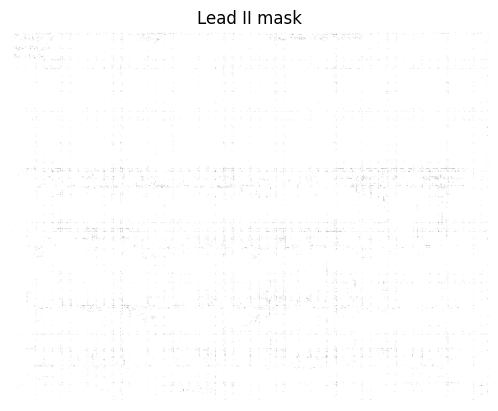

In [23]:
import matplotlib.pyplot as plt

lead_ii_mask = masks[0, 0]

plt.imshow(lead_ii_mask, cmap="gray")
plt.title("Lead II mask")
plt.axis("off")
plt.show()
